In [1]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import numpy as np
import re
import itertools
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import norm, svds
from scipy.sparse import csr_matrix, find
from scipy.stats import beta
import matplotlib.pyplot as plt
from helper_functions import *

# Real News or The Onion?

## Introduction

This notebook investigates if an article can be distinguished between “The Onion” and real news based on the text alone. Fake news is a hot topic in the national conscience these days, and it is important for people to be able to distinguish the two. This project addressed a small portion of this problem by addressing “The Onion.” “The Onion” is a satirical media company that publishes articles in a voice that are trying to mimic the tone and structure of traditional news reporting in a satirical way. Throughout “The Onions” existence, many prominent people and countries have fallen for their articles and believed them to be true. In 2012, “The Onion” ran an article that stated Kim Jong Un was the sexiest man alive for that year, and China picked up the story and ran with it as fact. There are even sub-reddits dedicated to examples of times people fell for different articles. In order to help people not fall for articles from “The Onion,” I built a model that can distinguish between articles from the satirical website, and actual news sources. 


## Data

### Combining the Data

Here I create three different dataframes (cnn_df, fox_df, onion_df) from the csv's that I created from the original data sources. 

In [34]:
cnn_df = pd.read_csv('data/cnn.csv')
fox_df = pd.read_csv('data/fox.csv')
onion_df = pd.read_csv('data/onion_csv.csv')

In [35]:
df_final = build_df(onion_df, fox_df, cnn_df)

The build_df function can be found in the helper_functions.py file. It does a little bit of cleaning by removing some punctuation, turning all the uppercase letters to lowercase letters, and removes the (CNN) that is at the beginning of all of the CNN articles. The build_df function also creates dummy variables for Satire, CNN, and Fox. It then takes 5000 CNN articles and 5000 Onion articles, and all of the Fox articles and puts them into one DataFrame with columns titled 'Article', 'Satire', 'CNN' and 'Fox'. Lastly it drops any articles that have less than 50 words.

Below is an example of what the Dataframe looks like.

In [37]:
df_final.head()

,Article,Satire,CNN,Fox
0,washington in a statement confirming his suppo...,1,0,0
1,washington irked that the attorney general’s b...,1,0,0
2,stamford ct lamenting that the numbers were mu...,1,0,0
3,nairobi kenya warning that a complete overhaul...,1,0,0
4,napa ca after being lovingly tended by generat...,1,0,0


### Average Word Count for Each Article Source

To find the word count for each article I used the word_count function that can be found in the helper_functions.py file. These word counts were then put into a dataframe in order to be graphed

In [38]:
onion_word_count = word_count(list(df_final.Article[0:4927]))
cnn_word_count = word_count(list(df_final.Article[4927:9927]))
fox_word_count = word_count(list(df_final.Article[9927:]))
word_counts_df = pd.DataFrame([['Onion', onion_word_count], ['CNN', cnn_word_count], ['Fox', fox_word_count]], columns=['Source', 'Average_Word_Count'])

The word_count_graph function can also be found in the helper_functions.py file. It converts the word_counts_df into a bar graph

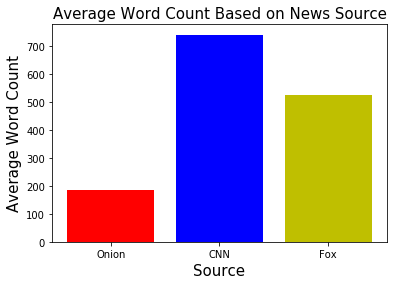

In [39]:
word_count_graph(word_counts_df)

### Final cleaning

The final_cleaner fucntion is used to eliminate unwanted characters, and words that slipped through the cracks. It can be found in the helper_functions.py file. Regular expression was used to select only characters in the alphabet, and remove 'fox' and 'news' from the corpus. The clean articles are inserted back into the dataframe and the dataframe is renamed to new_df_final

In [40]:
new_df_final = final_cleaner(df_final)

In [41]:
new_df_final

,Article,Satire,CNN,Fox
0,washington in a statement confirming his suppo...,1,0,0
1,washington irked that the attorney general s b...,1,0,0
2,stamford ct lamenting that the numbers were mu...,1,0,0
3,nairobi kenya warning that a complete overhaul...,1,0,0
4,napa ca after being lovingly tended by generat...,1,0,0
5,pineville la citing concerns over historically...,1,0,0
6,cambridge ma warning that nothing was more dan...,1,0,0
7,south bend in stumbling through the restaurant...,1,0,0
8,heaven speaking with obvious nostalgia regardi...,1,0,0
9,cary nc competing to secure the new pet s alle...,1,0,0


## Modeling 

A train, test split is used on the final dataframe for testing purposes. The docs_train and docs_test variables are the content of the articles, and the y_train, and y_test variables are the 'Satire' column, which indicates if the article is satirical or not. 

In [9]:
docs_train, docs_test, y_train, y_test = train_test_split(new_df_final['Article'], new_df_final['Satire'])

## Tokenizing and Stemming

#### This is a list of the stopwords used for the tokenization process. All of these words are not included in the final word corpus

#### This is the tokenization function that is used in the TfidfVectorizor. It tokenizes all of the words in an article, removes all the words that are less than 1 character, removes the stop words, and finally stems each word

### TFIDF Vectorization 

#### Grid search for min_df and max_df

In [ ]:
min_df_gs = [0,1,3,5,10,15,50,100]
max_df_gs = [1,.99,.95,.90,.75,.50,.25]

In [ ]:
parameters = {'min_df': min_df_gs, 'max_df': max_df_gs}

In [ ]:
vect_gs = TfidfVectorizer(tokenizer=tokenize2)

In [ ]:
clf = GridSearchCV(vect_gs, parameters)

In [ ]:
clf.fit(docs_train)

#### Here I vectorize the the articles using tfidf. A minimum term frequency of 3 and a maximum term frequency of 95% are used. The TfidfVectorizer also normalizes the tfidf. The training data is fit and transformed to the vectorizer to create X_train. The testing data is transformed into X_test

In [10]:
vect = TfidfVectorizer(tokenizer=main_tokenize)
# tune min_df and use max_df
X_train = vect.fit_transform(docs_train)
X_test = vect.transform(docs_test)

### Logistic Regression Model

#### The first model I used was a Logistic Regression model that could predict if the article was satirical or from a news source. The model was fit with the X_train data that had been vectorized, and the y_train data that is just a label that defines the article as being satire (1) or actual news (0)

In [11]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

/Users/jphooster22/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### Using the testing data (X_test, y_test) and the fit model (log_reg), I made predictions for what class the articles are predicted to be in. I then used the confusion matrix to calculate the F1 score, Precision and recall

In [ ]:
model_performance_score(log_reg, X_test, y_test)

### Naive Bayes Model

In [ ]:
#grid search for alpha

na_ba_1 = MultinomialNB(alpha=1)
na_ba_1.fit(X_train, y_train)

na_ba = MultinomialNB(alpha=.1)
na_ba.fit(X_train, y_train)

na_ba_0 = MultinomialNB(alpha=.0001)
na_ba_0.fit(X_train, y_train)


In [ ]:
model_performance_score(na_ba_1, X_test, y_test)

In [ ]:
model_performance_score(na_ba, X_test, y_test)

In [ ]:
model_performance_score(na_ba_0, X_test, y_test)

# Data Vis for Models

## Reciever Operating Characteristic Curves

#### Using the models above, I generated roc curves to show the diagnostic ability for the classification models

In [ ]:
roc_log_reg  = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1], pos_label=1)

roc_na_ba_1  = roc_curve(y_test, na_ba_1.predict_proba(X_test)[:,1], pos_label=1)
roc_na_ba  = roc_curve(y_test, na_ba.predict_proba(X_test)[:,1], pos_label=1)
roc_na_ba_0  = roc_curve(y_test, na_ba_0.predict_proba(X_test)[:,1], pos_label=1)


plt.figure()
lw = 2
plt.plot(roc_log_reg[0], roc_log_reg[1], color='darkorange',
         lw=lw, label='Logistic Regression')

plt.plot(roc_na_ba_1[0], roc_na_ba_1[1], color='b',
         lw=lw, label='Naive Bayes, Alpha=1')
plt.plot(roc_na_ba[0], roc_na_ba[1], color='c',
         lw=lw, label='Naive Bayes, Alpha=0.1')
plt.plot(roc_na_ba_0[0], roc_na_ba_0[1], color='r',
         lw=lw, label='Naive Bayes, Alpha=0.0001')


plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Confusion Matrices

#### Ploted the confusion matrices for the Naive Bayes model and Logistic Regression model

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
plot_confusion_matrix(confusion_matrix(y_test,log_reg.predict(X_test)),['F','T'], title='Logistic Regression Confusion Matrix')

In [ ]:
plot_confusion_matrix(confusion_matrix(y_test,na_ba_1.predict(X_test)),['F','T'], title='Naive Bayes(alpha=1) Confusion Matrix')

In [ ]:
plot_confusion_matrix(confusion_matrix(y_test,na_ba.predict(X_test)),['F','T'], title='Naive Bayes(alpha=1) Confusion Matrix')

In [ ]:
plot_confusion_matrix(confusion_matrix(y_test,na_ba_0.predict(X_test)),['F','T'], title='Naive Bayes(alpha=1) Confusion Matrix')

# Feature Exploration

#### This is an investigation in to which words are the strongest indicators for an article being from the onion or Fox News and CNN. The higher the beta coeffecient the stronger the relationship that word has to being associated with an article from the onion

In [ ]:
top_bot_words, bot_top_coef, sorted_BC_df = high_low_beta_coef(vect, log_reg)

In [ ]:
top_bot_words

In [ ]:
unstemed_top_bot_words = ['said',
 'trump',
 'told',
 'polic (police)',
 'accord (according)',
 'includ (include)',
 'peopl (people)',
 'twitter',
 'saturday',
 'clinton',
 'note',
 'just',
 'washington',
 'old',
 'sourc (source)',
 'confirm',
 'time',
 'press',
 'reportedly (reportedli)',
 'ad (added/adding)']

In [ ]:
data = bot_top_coef
labels = top_bot_words
fig, ax = plt.subplots(figsize=(15,12))

plt.bar(np.arange(len(data)), data, color = 'rrrrrrrrrrbbbbbbbbbb')
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
plt.setp( ax.xaxis.get_majorticklabels(), rotation=45, fontsize =20, ha='right', rotation_mode='anchor')
plt.setp( ax.yaxis.get_majorticklabels(), fontsize = 20)
ax.set_xticklabels(labels)
ax.set_title("10 Largest and Smallest Beta Coef for Words", fontsize = 20)
ax.set_ylabel("Beta Coef Value", fontsize = 20)
ax.set_xlabel("Word", fontsize = 20)

### Addressing the Ad issue

I was worried about the word ad having such a high beta coefficient, and wanted to make sure the webscrapper for the onion was not scrapping advertisements. To address this issue I ran the the logistic regression model and vectorizor without using the stemmer, and compared the results

In [ ]:
def tokenize_no_stemmer(doc):
    '''
    Tokenization function for the TFIDF vectorizor. This version of the tokenizer has no
    stemming function
    input: string of article
    output: list of article tokens that have been stemmed
    '''
    # Tokenizes each word in the document
    tokens = word_tokenize(doc)
    # Defines an empty list to append the stemmed words to
    cleaned_docs = []
    # Creates PorterStemmer object
    porter = PorterStemmer()
    # For loop to iterate through tokens in document
    for word in tokens:
    # Removes tokens that are just one character
        if len(word) < 2:
            tokens.remove(word)
    # Removes stop words from articles that are in test_stop_words 
    # list and appends porter stemmed words to the cleaned doc list
        else:
            if word not in test_stop_words:
                    cleaned_docs.append(word)
    # Returns list of tokens
    return cleaned_docs
    

#### Quick test of what the stemmer does to 'add' and 'advertisement. 

In [ ]:
porter = PorterStemmer()
porter.stem('add'), porter.stem('adverstisement'), porter.stem('added'), porter.stem('adding')

#### In this cell I use the TfidfVectorizor to vectorize the corpus. For this example I did not use the porter stemmer. I fit and transformed the training data with the vectorizeor. A min_df of 3 was used and a max_df of 95% was used. I then transformed the testing data based on the testing data. 

In [ ]:
vect_no_stem = TfidfVectorizer(tokenizer=tokenize_no_stemmer, min_df=3, max_df=.95)
# tune min_df and use max_df
X_train_no_stem = vect_no_stem.fit_transform(docs_train)
X_test_no_stem = vect_no_stem.transform(docs_test)

#### Here I fit a logistic regression model used the training data

In [ ]:
log_reg_no_stem = LogisticRegression()
log_reg_no_stem.fit(X_train_no_stem, y_train)

In [ ]:
top_bot_words_no_stem, bot_top_coef_no_stem, sorted_BC_df_no_stem = high_low_beta_coef(vect_no_stem, log_reg_no_stem)

#### Graph of the words with the 10 largest and smallest beta coef

In [ ]:
data = bot_top_coef_no_stem
labels = top_bot_words_no_stem
fig, ax = plt.subplots(figsize=(15,12))

plt.bar(np.arange(len(data)), data, color = 'rrrrrrrrrrbbbbbbbbbb')
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
plt.setp( ax.xaxis.get_majorticklabels(), rotation=45, fontsize =20, ha='right', rotation_mode='anchor')
plt.setp( ax.yaxis.get_majorticklabels(), fontsize = 20)
ax.set_xticklabels(labels)
ax.set_title("10 Largest and Smallest Beta Coef for Words (without stemming)", fontsize = 20)
ax.set_ylabel("Beta Coef Value", fontsize = 20)
ax.set_xlabel("Word", fontsize = 20)

Based on these results I can conclude that the word 'adding' is the one with a high beta coef and not some form of the word advertisement. 

### Election Stop Word Removal Modeling

In [ ]:
vect_election = TfidfVectorizer(tokenizer=tokenize_election, min_df=3, max_df=.95)

X_train_election = vect_election.fit_transform(docs_train)
X_test_election = vect_election.transform(docs_test)

In [ ]:
log_reg_election = LogisticRegression()
log_reg_election.fit(X_train_election, y_train)

In [ ]:
top_bot_words_election, bot_top_coef_election, sorted_BC_df_election = high_low_beta_coef(vect_election, log_reg_election)

In [ ]:
data = bot_top_coef_election
labels = top_bot_words_election
fig, ax = plt.subplots(figsize=(15,12))

plt.bar(np.arange(len(data)), data, color = 'rrrrrrrrrrbbbbbbbbbb')
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
plt.setp( ax.xaxis.get_majorticklabels(), rotation=45, fontsize =20, ha='right', rotation_mode='anchor')
plt.setp( ax.yaxis.get_majorticklabels(), fontsize = 20)
ax.set_xticklabels(labels)
ax.set_title("10 Largest and Smallest Beta Coef for Words (election stopwords)", fontsize = 20)
ax.set_ylabel("Beta Coef Value", fontsize = 20)
ax.set_xlabel("Word", fontsize = 20)

### Average Magnitude of TFIDF Vector for Satire and News

In [ ]:
Satire_mag, News_mag = avg_tfidf_mag(X_train, y_train)

In [ ]:
Satire_mag, News_mag

In [ ]:
fig, ax = plt.subplots(figsize= (8,8))
plt.bar(['Satire', 'News'],[Satire_mag, News_mag], color ='rby')
ax.set_title("Average Magnitude of Article Vector", fontsize = 15)
ax.set_ylabel("Magnitude", fontsize = 15)
ax.set_xlabel("Type of Article", fontsize = 15)

### Sample Trump Article

In [12]:
sample = 'WASHINGTON—Following the announcement that Homeland Security Secretary Kirstjen Nielsen was leaving her post, President Trump told reporters Monday he would conduct an extensive search to find a replacement with the right personality disorders necessary for the role. “Though I admired Kirstjen’s ability to remain cold and detached when questioned about the decision to tear apart families at the border, we require someone with an even greater lack of empathy to do this job properly,” said the president, who praised Nielsen for putting children in cages but explained that the ideal candidate for the position must possess a degree of psychopathy so severe that they believe no law or moral code of any kind applies to them. “The next person to head the department must be blessed with strong narcissistic tendencies, of course, but also a consistent record of profoundly antisocial behavior. We need someone both spiteful and cruel, but also willing to totally disregard right and wrong. Basically, the new secretary will need to have a psychological makeup that allows them to look people in the eye and tell them, without hesitation, that we don’t want any non-Americans entering the United States unless they’re coming from one of a very limited group of countries in northern Europe.” At press time, a team of psychiatrists had reportedly presented the president with a stack of résumés that consisted solely of individuals housed in supermax prisons and White House senior adviser Stephen Miller.'

In [13]:
len(sample.split())

240

In [15]:
clean_sample = single_article_cleaner(sample)

In [16]:
probas_word_removal, minword, maxword = onion_prob_word_removal(vect, clean_sample, log_reg)

In [19]:
minword, maxword

('reportedli', 'trump')

Text(0.5, 0, 'Index for Word Removed')

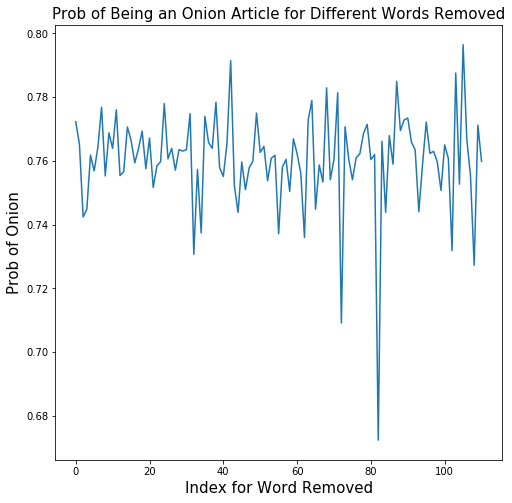

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
plt.plot(probas_word_removal)
ax.set_title("Prob of Being an Onion Article for Different Words Removed", fontsize = 15)
ax.set_ylabel("Prob of Onion", fontsize = 15)
ax.set_xlabel("Index for Word Removed", fontsize = 15)

### Test for half of a CNN article

In [20]:
cnn_test = 'report to the committee," Barr said.Barrs comments Tuesday come ahead of a brewing clash between Congress and the Trump administration over the Mueller report, as Democrats are indeed prepared to go to court in an effort to obtain the unredacted Mueller report and the special counsels underlying evidence. Democrats on the House Judiciary Committee have already authorized a subpoena for the full Mueller report and the underlying evidence, which House Judiciary Chairman Jerry Nadler said Tuesday he is waiting to see what Barr releases before moving forward on the subpoena. "The question is what we receive -- do we receive a full copy of the Mueller Report and the documentation underneath it?" Nadler said. "Do we receive most of it with a little redaction or do they completely expurgate it? Well have to take a look at it." Asked Tuesday about the grand jury material, Barr told a House Appropriations subcommittee: "The chairman of the Judiciary Committee is free to go to court." Four types of information would be redacted from the report he submits, Barr said, including grand jury material, classified information, material tied to ongoing investigation, and information that could harm "peripheral third parties."'

In [21]:
len(cnn_test.split())

196

In [33]:
cnn_clean_sample = single_article_cleaner(cnn_test)
cnn_vect_sample = vect.transform(cnn_clean_sample)
print(log_reg.predict_proba(cnn_vect_sample))
log_reg.predict(cnn_vect_sample)

[[0.70511485 0.29488515]]


array([0])

### Distribution of Cosine Sim between 100 CNN articles and 100 Onion articles

Distributions


100 random vectors from onion and CNN
cosine sim CNN CNN CNN onion
cosine sim sqore for 100 of each 


Similarity in language in CNN vs onion

In [ ]:
X_train

In [ ]:
y_t_arr = np.array(y_train)

In [ ]:
sat_X_train= X_train[y_t_arr==1]
news_X_train = X_train[y_t_arr==0]

In [ ]:
samp_sat_X_train = sat_X_train[0:100]
samp_news_X_train = news_X_train[0:100]

In [ ]:
samp_news_X_train[99]

In [ ]:
cosine_similarity(samp_sat_X_train[0],samp_news_X_train[0])

In [ ]:
sat_sims = cosine_similarity(samp_sat_X_train)

In [ ]:
news_sims = cosine_similarity(samp_news_X_train)

In [ ]:
combo_sims = cosine_similarity(samp_sat_X_train, samp_news_X_train)

In [ ]:
sat_sims_tril = np.tril(sat_sims,-1)
sat_sims_flat = sat_sims_tril.flatten()
final_sat_sims = sat_sims_flat[sat_sims_flat != 0]

In [ ]:
len(final_sat_sims)

In [ ]:
news_sims_tril = np.tril(news_sims,-1)
news_sims_flat = news_sims_tril.flatten()
final_news_sims = news_sims_flat[news_sims_flat != 0]

In [ ]:
final_combo_sims = combo_sims.flatten()
len(final_combo_sims)

In [ ]:
np.mean(final_combo_sims)

In [ ]:
np.mean(final_sat_sims)

In [ ]:
np.mean(final_news_sims)

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))

combo_hist =plt.hist(final_combo_sims, bins=200, range=(0,.5), label='Cosine Similarity Between News and Satire Articles', normed=True)
sat_hist = plt.hist(final_sat_sims, bins=200, range=(0,.5), label='Cosine Similarity for Satirical Articles',normed=True)
news_hist = plt.hist(final_news_sims, bins=200, range=(0,.5), label= 'Cosine Similarity for News Articles',normed=True)

ax.set_title("Cosine Similarity Distribution Between News and Satire articles", fontsize = 25)
ax.set_ylabel("Count", fontsize = 20)
ax.set_xlabel("Cosine Similarity", fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

In [ ]:
snark_test = 'Aaron Rodgers went down with a leg injury during Week 1 of the 2018 season in the Packers’ Sunday Night Football game against the Chicago Bears in Green Bay. In a seemingly miraculous turn of events, Rodgers was able to return to the field in relief of backup QB DeShone Kiser who took for the Packers over after the injury, and lead the Packers to a comeback win. Though Rodgers was able to play out the year, we now know that the injury affected the Green Bay Packers quarterback throughout the entire 2018 season. Rodgers appeared on the “Wilde and Tausch” show of ESPN Wisconsin this week and revealed that he suffered not only a sprained MCL, but fractured his tibia in his leg leg during the 2nd quarter sack that caused the injury in that game against Chicago. “If you watch the hit back,” Rodgers said, “just my two bones are coming together on the outside, just kind of made an indent fracture. Very painful. The good thing was it’s not super weight bearing, like load bearing every single time. but there definitely was some movement and things you do naturally that affected it.” A tibial plateau fracture is a break of the upper part of the shinbone and takes months to recover from. For reference, J.J. Watt and Kobe Bryant have both suffered the same injury. Watt missed the entire rest of the season and Bryant missed months. “I really wasn’t 100 percent the entire year,” Rodgers noted during the interview. “I’m proud of the fact that I started 16 games. It’s disappointing how it ended.”'

In [ ]:
clean_snark = new_cleaner(snark_test)

In [ ]:
snark_vect = vect.transform(clean_snark)

In [ ]:
log_reg.predict(snark_vect)

In [ ]:
log_reg.predict_proba(snark_vect)